# Implementação do Random Forest

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pandas import DataFrame
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

TRAINING_DATASET_SOURCE = '../training_data.csv'  # Since we are one directory up, we should go down one directory to import the datasets
TEST_DATASET_SOURCE = '../test_data.csv'

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# Definição dos dados de teste e de treino

In [321]:
print(train_df.shape, test_df.shape)
print(train_df['incidents'].value_counts())

incidents_count = train_df['incidents'].value_counts()

max_count = incidents_count.max()
print('Max value count:', max_count)

df_classes = []
for category, counts in zip(incidents_count.index, incidents_count):
    #print(category, counts)
    df_classes.append(train_df[train_df['incidents'] == category])

df_classes_over = []

for category in df_classes:
    df_classes_over.append(category.sample(max_count, replace=True))

df_test_over = pd.concat(df_classes_over, axis=0)

print(df_test_over['incidents'].value_counts())


(5000, 13) (1206, 12)
None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64
Max value count: 2028
None         2028
High         2028
Low          2028
Very_High    2028
Medium       2028
Name: incidents, dtype: int64


In [322]:
features = df_test_over.drop(['incidents'], axis=1)
target = df_test_over['incidents']

all_features = features.columns.tolist()

features[:5]

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
1822,Guimaraes,UNDEFINED,0,",",2021-03-15 04:00,DARK,10.0,1025.0,76.0,2.0,0.0,Sem Chuva
1906,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-04 20:00,DARK,15.0,1022.0,83.0,1.0,0.0,Sem Chuva
950,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-30 05:00,DARK,15.0,1003.0,93.0,0.0,0.0,Sem Chuva
3530,Guimaraes,UNDEFINED,0,",",2021-03-07 04:00,DARK,8.0,1017.0,81.0,0.0,0.0,Sem Chuva
4739,Guimaraes,UNDEFINED,0,"N101,N101",2021-12-05 23:00,DARK,9.0,1028.0,89.0,0.0,0.0,Sem Chuva


### Obtenção das features numericas e categoricas

In [336]:
from sklearn.preprocessing import StandardScaler

categorical_to_numerical = {
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2
    },
    'avg_rain': {
        'Sem Chuva': 0,
        'chuva fraca': 1,
        'chuva moderada': 2,
        'chuva forte': 3,
    }
}


def decision_tree_data_preparation(df: DataFrame) -> DataFrame:
    dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay']

    numerical_features = [column for column, dtype in zip(features.columns, features.dtypes) if
                          dtype.kind in ['i', 'f'] and column not in dropped_columns]

    numerical_features = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'luminosity']
    #assert numerical_features == ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'luminosity']


    categorical_features = [column for column, dtype in zip(features.columns, features.dtypes) if
                            dtype.kind not in ['i', 'f'] and column not in dropped_columns]

    prep_df = df.drop(dropped_columns, axis=1)
    prep_df.drop_duplicates()

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['hour'] = record_date.hour
    prep_df['day'] = record_date.day
    prep_df['month'] = record_date.month
    prep_df['weekday'] = record_date.weekday

    prep_df.drop(columns=['record_date'], inplace=True)

    #train_df['affected_roads'] = train_df['affected_roads'].fillna(train_df['affected_roads'].mode().iloc[0])

    num_affected_roads = []
    for line in df['affected_roads']:
        unique_roads = set(str(line).split(','))
        valid_roads = [elem for elem in unique_roads if elem != '']
        count = len(valid_roads)
        num_affected_roads.append(count)

    prep_df['num_affected_roads'] = num_affected_roads

    ### Ao analisar o resultado pós-tratamento, verificámos que a feature 'affected_roads' tinha alta correlação com 'delay_in_minutes'
    prep_df.drop(columns=['affected_roads'], inplace=True)

    ### Converter a feature 'delay_in_seconds' para 'delay_in_minutes' de modo a reduzir o intervalo de valores
    delay_in_minutes = prep_df['delay_in_seconds'].map(lambda seconds : seconds / 60)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes

    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    #numerical_features.remove('delay_in_seconds')
    #numerical_features.append('delay_in_minutes')

    scaler = MinMaxScaler()
    scaler.fit(prep_df)
    prep_df = scaler.transform(prep_df)


    return prep_df

### Divisão dos dados em dados de teste e treino

In [337]:
X_train, X_test, y_train, y_test = train_test_split(decision_tree_data_preparation(features), target, test_size=0.3,
                                                    random_state=2000)

### Preparação de dados

In [340]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = make_pipeline(
    RandomForestClassifier(random_state=200))

In [341]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

1.0

In [342]:
RF_Model.score(X_test, y_test)

0.9796186719263642

## Hyperparameter Tuning

In [343]:
import numpy as np

n_estimators = [100, 200] #[int(x) for x in np.linspace(start=10, stop=500, num=5)]

max_features = [int(x) for x in np.linspace(start=6, stop=12, num=3)]

max_depth = [int(x) for x in np.linspace(start=10, stop=500, num=5)]

min_samples_split = [int(x) for x in np.linspace(start=2, stop=30, num=2)]  #[2, 5, 10, 20]

min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=30, num=2)]  # [1, 2, 5, 10]

max_leaf_nodes = [int(x) for x in np.linspace(start=20, stop=200, num=5)]

bootstrap = [True, False]

criterions = ["gini", "entropy", "log_loss"]

In [344]:
param_grid = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__max_leaf_nodes': max_leaf_nodes,
    'randomforestclassifier__bootstrap': bootstrap,
    'randomforestclassifier__criterion': criterions
}

param_grid

{'randomforestclassifier__n_estimators': [100, 200],
 'randomforestclassifier__max_features': [6, 9, 12],
 'randomforestclassifier__max_depth': [10, 132, 255, 377, 500],
 'randomforestclassifier__min_samples_split': [2, 30],
 'randomforestclassifier__min_samples_leaf': [2, 30],
 'randomforestclassifier__max_leaf_nodes': [20, 65, 110, 155, 200],
 'randomforestclassifier__bootstrap': [True, False],
 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [349]:
from sklearn.metrics import accuracy_score
rf_RandomGrid = RandomizedSearchCV(estimator=RF_Model, param_distributions=param_grid, cv=20, verbose=1, n_jobs=-2,
                                   n_iter=20, random_state=1000, scoring=accuracy_score)
#rf_RandomGrid = GridSearchCV(estimator=RF_Model, param_grid=param_grid, cv=10, verbose=1, n_jobs=-1, scoring='balanced_accuracy')

In [350]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 20 folds for each of 20 candidates, totalling 400 fits


C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


CPU times: total: 2.38 s
Wall time: 1min 1s


RandomizedSearchCV(cv=20,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(random_state=200))]),
                   n_iter=20, n_jobs=-2,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [10,
                                                                              132,
                                                                              255,
                                                                              377,
                                                                              500],
                                        'randomforestclassifier__max_features': [6,
                                                                                 9,
                                                                                 12],
                                        'randomforestclassifier__max_leaf_nodes': [20,
                                                                                   65,
                                                                                   110,
                                                                                   155,
                                                                                   200],
                                        'randomforestclassifier__min_samples_leaf': [2,
                                                                                     30],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      30],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 200]},
                   random_state=1000,
                   scoring=<function accuracy_score at 0x000001C89B8DBCA0>,
                   verbose=1)

In [351]:
print("Cross Validation results:", rf_RandomGrid.cv_results_)

print("RandomGrid best score:", rf_RandomGrid.best_score_)

print(f'Train: {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test: {rf_RandomGrid.score(X_test, y_test):.3f}')

rf_RandomGrid.best_estimator_

Cross Validation results: {'mean_fit_time': array([1.62969838, 2.08684944, 2.50670187, 2.61969931, 1.57754989,
       0.95219892, 2.00119972, 2.02909927, 1.02384864, 3.19139886,
       1.57659928, 2.69434977, 0.8344992 , 1.70414944, 1.37920028,
       2.1048496 , 1.42034916, 1.15994915, 3.83769948, 1.10884955]), 'std_fit_time': array([0.12606187, 0.10885542, 0.08285436, 0.10862432, 0.06290114,
       0.07093292, 0.06240011, 0.09153577, 0.05625207, 0.12654817,
       0.10928222, 0.12648706, 0.10197045, 0.06859505, 0.03635886,
       0.19353672, 0.10515927, 0.05848607, 0.16581453, 0.09825468]), 'mean_score_time': array([0.0004501 , 0.00020013, 0.00029755, 0.00030006, 0.00019995,
       0.00029981, 0.00024984, 0.00034993, 0.0004004 , 0.00035019,
       0.00030006, 0.0001999 , 0.00019995, 0.00035065, 0.00049982,
       0.00029987, 0.00040021, 0.00029997, 0.0002502 , 0.00030011]), 'std_score_time': array([0.0004976 , 0.00040026, 0.00045461, 0.00045835, 0.00050986,
       0.00045797, 0.00043

TypeError: accuracy_score() takes 2 positional arguments but 3 were given

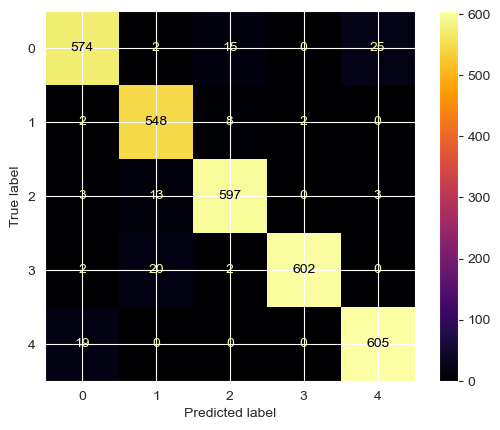

In [348]:
predictions = rf_RandomGrid.predict(X_test)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap='inferno')

### Obtenção das previsões do dataset de submissão

In [334]:
test_data = test_df.copy()

test_data_prepared = decision_tree_data_preparation(test_data)

predictions = rf_RandomGrid.predict(test_data_prepared) #RF_Model.predict(test_data_prepared)
predictions_df = pd.DataFrame(predictions)
predictions_df.index += 1
predictions_df.to_csv("../submission_v2.csv", header=['Incidents'], index_label='RowId')